In [311]:
import numpy as np
from matplotlib import pyplot as plt 

In [312]:
def load_data(filename):
    mylist = np.genfromtxt(filename, delimiter=',')
    return mylist

In [313]:
data_list = load_data('PCA_MNIST.csv') #this csv file contains the KMNIST data 
# num_classes = 10
# num_features = 10

def train_data(a,b):
    feature_list = []
    labels = []
    for row in data_list[a+1:b+1,1:len(data_list.T)]:
        feature_list.append(row)
    for row in data_list[a+1:b+1,0]:
        y_val = ['1']
        y_val[0] = row
        labels.append(y_val)
    #print (np.array(feature_list[:2]), labels[:10])
    return np.array(feature_list), np.array(labels)

In [314]:
def data_split(m):
    np.random.shuffle(data_list[1:]) # shuffle before splitting into test and training sets

    X_train, Y_train = train_data(0,int(m*60000))
    X_test , Y_test = train_data(int(m*60000),60000)

    X_train = np.array(X_train) 
    X_train = X_train.T/10  # data divided by 10 to reduce the number of thresholds
    X_test = np.array(X_test)
    X_test = X_test.T/10

    m = len(Y_train)
    print (len(X_train[0]))
    return X_train, Y_train, X_test , Y_test

In [315]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [517]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, impurity, thresh, curr_depth=0):
        ''' recursive function to build the tree ''' 
        #print(curr_depth)
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            print(curr_depth,self.max_depth)
            best_split = self.get_best_split(dataset, num_samples, num_features, impurity, thresh)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], impurity, thresh, curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], impurity, thresh, curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features, impurity, thresh='integer'):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            if thresh == "integer":
                possible_thresholds = np.unique(np.round_(feature_values))
            elif thresh == "2X_thresholds":
                possible_thresholds = np.unique(np.round_(feature_values*2))
            #print(feature_index,"--thresholds--",np.size(possible_thresholds))
            # loop over all the feature values present in the data
            #print("imp2", impurity)
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, impurity)
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="entropy":
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        elif mode=="entropy_10":
            gain = self.entropy_10(parent) - (weight_l*self.entropy_10(l_child) + weight_r*self.entropy_10(r_child))
        else:
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def entropy_10(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log10(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y, impurity= 'gini', thresh = 'integer'):
        ''' function to train the tree '''
        
        print ("impurity-",impurity,";  Thresholds- ",thresh)
        dataset = np.concatenate((X, Y), axis=1)
        print (dataset)
        self.root = self.build_tree(dataset, impurity, thresh)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [498]:
def accuracy_calc(X_test, Y_test):
    Y_pred = classifier.predict(X_test.T) 
    Y_test_= []
    for y in Y_test:
        Y_test_.append(y[0])
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(Y_test_, Y_pred)
    return acc

In [328]:
def plot(A, B, xlabel, ylabel, title):
    plt.plot(A, B)
  
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.title(title)
    plt.show()

In [472]:
X_train, Y_train, X_test , Y_test = data_split(0.5)

classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train,'gini')

classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

30000
impurity- gini ;  Thresholds-  integer
[[-49.23737787  11.19300058 -33.25039635 ...  -9.15105453 -37.60279413
    3.        ]
 [ 74.80114843 -46.98223266  31.54128376 ... -45.78826763   3.78555979
    0.        ]
 [ 42.52147687  -0.60189235  23.75673339 ... -27.81976264  39.10815908
    1.        ]
 ...
 [ -3.29547223  32.64446556  44.35506847 ...   3.85917405  19.80989795
    5.        ]
 [  1.779789   112.60415753  -4.82926749 ... -31.81827521  -7.42344711
    2.        ]
 [ 78.68697563 -23.26032907  30.08435942 ... -10.86556172   6.91754797
    8.        ]]


KeyboardInterrupt: 

In [330]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train, 'entropy')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

impurity- entropy ;  Thresholds-  integer
X_0 <= -18.0 ? 0.5934766711071444
 left:X_2 <= 4.0 ? 0.4400246693089438
  left:X_1 <= -19.0 ? 0.5299504026268917
    left:X_5 <= 22.0 ? 0.3957655664179196
        left:X_4 <= 18.0 ? 0.3379420577790171
                left:X_7 <= -11.0 ? 0.20643676431858693
                                left:7.0
                                right:6.0
                right:X_5 <= 0.0 ? 0.3944487052551777
                                left:3.0
                                right:7.0
        right:X_9 <= 25.0 ? 0.07641417055286126
                left:X_5 <= 30.0 ? 0.04662087777515078
                                left:7.0
                                right:7.0
                right:X_8 <= -5.0 ? 0.3475093997565859
                                left:7.0
                                right:6.0
    right:X_9 <= 9.0 ? 0.2554913769185714
        left:X_0 <= -30.0 ? 0.13995590258795398
                left:X_2 <= -10.0 ? 0.04668672255317735
           

In [331]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train, 'entropy_10')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

impurity- entropy_10 ;  Thresholds-  integer
X_0 <= -18.0 ? 0.17865427973005765
 left:X_2 <= 4.0 ? 0.1324606242941162
  left:X_1 <= -19.0 ? 0.15953096740489825
    left:X_5 <= 22.0 ? 0.11913730674273931
        left:X_4 <= 18.0 ? 0.10173069618789454
                left:X_7 <= -11.0 ? 0.06214365826771062
                                left:7.0
                                right:6.0
                right:X_5 <= 0.0 ? 0.11874089203262905
                                left:3.0
                                right:7.0
        right:X_9 <= 25.0 ? 0.023002957430194593
                left:X_5 <= 30.0 ? 0.014034282634504652
                                left:7.0
                                right:7.0
                right:X_8 <= -5.0 ? 0.10461075310191781
                                left:7.0
                                right:6.0
    right:X_9 <= 9.0 ? 0.07691056808598212
        left:X_0 <= -30.0 ? 0.04213092474920038
                left:X_2 <= -10.0 ? 0.01405410388774845

In [338]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train, 'gini', '2X_thresholds')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

impurity- gini ;  Thresholds-  2X_thresholds
X_0 <= -23.0 ? 0.07264078774302773
 left:X_4 <= -9.0 ? 0.13737377826388308
  left:X_5 <= 14.0 ? 0.07696768917055974
    left:X_3 <= -21.0 ? 0.058216816409656535
        left:X_4 <= -38.0 ? 0.1559906626415022
                left:X_2 <= 63.0 ? 0.030318557273198044
                                left:6.0
                                right:6.0
                right:X_9 <= 12.0 ? 0.08850038896748297
                                left:7.0
                                right:6.0
        right:X_2 <= -15.0 ? 0.031135075739558538
                left:X_1 <= -0.0 ? 0.26655233816952995
                                left:6.0
                                right:3.0
                right:X_4 <= -35.0 ? 0.019781835305853812
                                left:6.0
                                right:6.0
    right:X_9 <= 25.0 ? 0.10216204642641324
        left:X_0 <= -73.0 ? 0.01766447398738344
                left:X_9 <= 21.0 ? 0.01022647713

Train : Test = 1 : 9
6000
impurity- gini ;  Thresholds-  integer
X_0 <= -23.0 ? 0.07433748257143757
 left:X_4 <= -10.0 ? 0.1473014261889387
  left:X_4 <= -28.0 ? 0.07769048416482643
    left:X_3 <= -33.0 ? 0.029287078279563117
        left:7.0
        right:6.0
    right:X_3 <= -17.0 ? 0.0716560984613962
        left:7.0
        right:6.0
  right:X_5 <= 23.0 ? 0.16713971076478096
    left:X_2 <= 2.0 ? 0.1113433597319724
        left:3.0
        right:2.0
    right:X_1 <= -4.0 ? 0.3175908855832452
        left:7.0
        right:2.0
 right:X_3 <= -1.0 ? 0.08165648918902335
  left:X_4 <= -30.0 ? 0.1410113147939821
    left:X_2 <= 18.0 ? 0.033296000554685616
        left:9.0
        right:1.0
    right:X_1 <= 49.0 ? 0.16129756558176855
        left:1.0
        right:2.0
  right:X_2 <= -29.0 ? 0.14933472502184697
    left:X_1 <= -24.0 ? 0.09586833990433397
        left:7.0
        right:4.0
    right:X_1 <= 10.0 ? 0.15948805893348617
        left:8.0
        right:5.0
Accuracy of the Tree- 

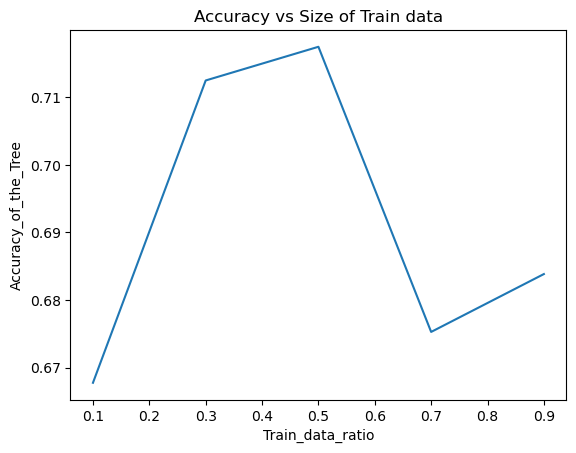

In [332]:
a = 1
split = []
accuracy = []
while a < 10:
    print ('Train : Test =', a,':',10-a )
    X_train, Y_train, X_test , Y_test = data_split(a*0.1)
    classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
    classifier.fit(X_train.T,Y_train)
    classifier.print_tree()
    split.append(a*0.1)
    acc = accuracy_calc( X_test, Y_test)
    accuracy.append(acc)
    print ('Accuracy of the Tree-', acc)
    a = a+2
    
print ('split-', split) 
print ('accuracy-', accuracy) 
plot ( split, accuracy, "Train_data_ratio", "Accuracy_of_the_Tree", "Accuracy vs Size of Train data")

Depth of the Tree = 3
30000
impurity- gini ;  Thresholds-  integer
X_0 <= -23.0 ? 0.07243462975017023
 left:X_4 <= -15.0 ? 0.1387311677006151
  left:X_4 <= -34.0 ? 0.06281745741716
    left:X_3 <= -29.0 ? 0.016609532382067554
        left:6.0
        right:6.0
    right:X_3 <= -17.0 ? 0.07550766532697045
        left:7.0
        right:6.0
  right:X_1 <= -18.0 ? 0.16944603969533656
    left:X_5 <= 23.0 ? 0.14954238087154703
        left:6.0
        right:7.0
    right:X_2 <= 9.0 ? 0.2182550781209036
        left:3.0
        right:2.0
 right:X_3 <= -2.0 ? 0.08243005801551229
  left:X_5 <= 12.0 ? 0.14064112499949366
    left:X_1 <= -33.0 ? 0.16628258909222027
        left:0.0
        right:1.0
    right:X_1 <= 52.0 ? 0.22388523102205632
        left:9.0
        right:2.0
  right:X_2 <= -28.0 ? 0.15189321739557093
    left:X_1 <= -19.0 ? 0.09567969964867917
        left:7.0
        right:4.0
    right:X_1 <= 10.0 ? 0.15663962829569278
        left:8.0
        right:5.0
Accuracy of the Tree

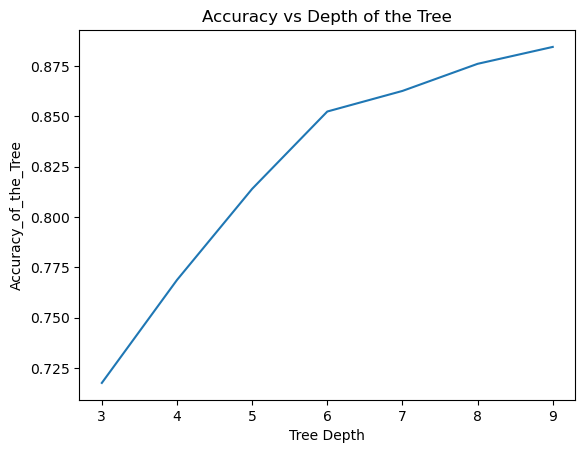

In [333]:
a = 3
spl = []
accuracy = []
while a < 10:
    print ('Depth of the Tree =', a )
    X_train, Y_train, X_test , Y_test = data_split(0.5)
    classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=a)
    classifier.fit(X_train.T,Y_train)
    classifier.print_tree()
    spl.append(a)
    acc = accuracy_calc( X_test, Y_test)
    accuracy.append(acc)
    print ('Accuracy of the Tree-', acc)
    a = a+1
    
print ('Depths-', spl) 
print ('accuracies-', accuracy) 
plot ( spl, accuracy, "Tree Depth", "Accuracy_of_the_Tree", "Accuracy vs Depth of the Tree")

In [334]:
# Y_pred = classifier.predict(X_test.T) 
# print(Y_pred[:10])
# Y_test_= []
# for y in Y_test:
#     Y_test_.append(y[0])
# print(Y_test_[:10])
# from sklearn.metrics import accuracy_score
# accuracy_score(Y_test_, Y_pred)

In [535]:
def bootstrap_samples( X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
#     print (n_samples)
#     print (idxs)
#     print (X[idxs])
    return X[idxs], y[idxs]

In [536]:
def choose_features( n, X ):  
    n_features = n
    total_features =X.shape[0]
    idxs = np.random.choice(total_features, n_features, replace=False)
    n_val = X.T.shape[0]
    print (idxs)
    dataset = X[idxs[0]].reshape(n_val, 1)
    for i in range (n_features):
        dataset = np.concatenate( (dataset, X[idxs[i]].reshape(n_val, 1)), axis=1)
    dataset = dataset.T
#     print (dataset[1:n_features+1])
    return dataset[1:n_features+1]

In [537]:
def max_count (y):
    count_dict = {}
    for num in y:
        if num in count_dict:
            count_dict[num] += 1
        else:
            count_dict[num] = 1
    max_count = 0
    max_num = None
    for num, count in count_dict.items():
        if count > max_count:
            max_count = count
            max_num = num
    return max_num
    
    return most_common

In [538]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=2, min_samples_split=2, n_feature=4):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit_forest(self, X, Y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(self.min_samples_split, self.max_depth)
            X_partial = choose_features(self.n_features , X.T)
            #print(X_partial)
            X_sample, y_sample = bootstrap_samples(X_partial.T, Y)
            tree.fit(X_sample, y_sample)
            print ('tree done')
            tree.print_tree()
            self.trees.append(tree)



    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([max_count(pred) for pred in tree_preds])
        return predictions

In [541]:
X_train, Y_train, X_test , Y_test = data_split(0.5)
forest = RandomForest(n_trees=3, max_depth=3, min_samples_split=3)
forest.fit_forest(X_train.T, Y_train)
y_pred = forest.predict(X_test)
print (Y_test, y_pred)

30000
[5 6 3 1]
impurity- gini ;  Thresholds-  integer
[[ 12.16122205  17.61080582  31.81957926  27.98322059   3.        ]
 [-17.89162441   6.0580547    8.79647391 -38.88180174   6.        ]
 [ -7.86476322  17.24847147  25.33714929   2.90918698   4.        ]
 ...
 [-28.46079501 -29.99546452 -66.45274789 -13.15706984   1.        ]
 [-16.95004699  -0.30999113  18.91848762  19.84060425   5.        ]
 [-19.72951461  -0.25393117 -37.21287947 -39.71964419   0.        ]]
0 1
1 1
1 1
tree done
X_3 <= 61.0 ? 0.06447465542890474
 left:X_2 <= -19.0 ? 0.0502474414234626
  left:1.0
  right:5.0
 right:X_2 <= 22.0 ? 0.028181837312887772
  left:2.0
  right:5.0
[4 8 2 9]
impurity- gini ;  Thresholds-  integer
[[ 32.51943668 -34.2379972  -45.30277473   9.82226643   7.        ]
 [ -0.41239878   6.80867806   3.17753794  17.2529539    1.        ]
 [-41.1859219   28.75797658 -41.05235612  11.84631463   9.        ]
 ...
 [ 48.14501482  22.87132296   6.21879558 -43.88375982   0.        ]
 [ 61.9117797   30.91

NameError: name 'y_test' is not defined

In [542]:
y_pred = forest.predict(X_test)
print (Y_test, y_pred)

[[1.]
 [2.]
 [0.]
 ...
 [9.]
 [5.]
 [1.]] [5. 1. 8. 1. 8. 8. 8. 1. 1. 5.]


In [311]:
import numpy as np
from matplotlib import pyplot as plt 

In [312]:
def load_data(filename):
    mylist = np.genfromtxt(filename, delimiter=',')
    return mylist

In [313]:
data_list = load_data('PCA_MNIST.csv') #this csv file contains the KMNIST data 
# num_classes = 10
# num_features = 10

def train_data(a,b):
    feature_list = []
    labels = []
    for row in data_list[a+1:b+1,1:len(data_list.T)]:
        feature_list.append(row)
    for row in data_list[a+1:b+1,0]:
        y_val = ['1']
        y_val[0] = row
        labels.append(y_val)
    #print (np.array(feature_list[:2]), labels[:10])
    return np.array(feature_list), np.array(labels)

In [314]:
def data_split(m):
    np.random.shuffle(data_list[1:]) # shuffle before splitting into test and training sets

    X_train, Y_train = train_data(0,int(m*60000))
    X_test , Y_test = train_data(int(m*60000),60000)

    X_train = np.array(X_train) 
    X_train = X_train.T/10  # data divided by 10 to reduce the number of thresholds
    X_test = np.array(X_test)
    X_test = X_test.T/10

    m = len(Y_train)
    print (len(X_train[0]))
    return X_train, Y_train, X_test , Y_test

In [315]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [335]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, impurity, thresh, curr_depth=0):
        ''' recursive function to build the tree ''' 
        #print(curr_depth)
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            #print("imp1", impurity)
            best_split = self.get_best_split(dataset, num_samples, num_features, impurity, thresh)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], impurity, thresh, curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], impurity, thresh, curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features, impurity, thresh='integer'):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            if thresh == "integer":
                possible_thresholds = np.unique(np.round_(feature_values))
            elif thresh == "2X_thresholds":
                possible_thresholds = np.unique(np.round_(feature_values*2))
            #print(feature_index,"--thresholds--",np.size(possible_thresholds))
            # loop over all the feature values present in the data
            #print("imp2", impurity)
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, impurity)
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="entropy":
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        elif mode=="entropy_10":
            gain = self.entropy_10(parent) - (weight_l*self.entropy_10(l_child) + weight_r*self.entropy_10(r_child))
        else:
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def entropy_10(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log10(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y, impurity= 'gini', thresh = 'integer'):
        ''' function to train the tree '''
        
        print ("impurity-",impurity,";  Thresholds- ",thresh)
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset, impurity, thresh)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [327]:
def accuracy_calc(X_test, Y_test):
    Y_pred = classifier.predict(X_test.T) 
    Y_test_= []
    for y in Y_test:
        Y_test_.append(y[0])
    from sklearn.metrics import accuracy_score
    acc = accuracy_score(Y_test_, Y_pred)
    return acc

In [328]:
def plot(A, B, xlabel, ylabel, title):
    plt.plot(A, B)
  
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.title(title)
    plt.show()

In [337]:
X_train, Y_train, X_test , Y_test = data_split(0.5)
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train,'gini')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

30000
impurity- gini ;  Thresholds-  integer
X_0 <= -23.0 ? 0.07264078774302773
 left:X_4 <= -9.0 ? 0.13737377826388308
  left:X_5 <= 14.0 ? 0.07696768917055974
    left:X_3 <= -21.0 ? 0.058216816409656535
        left:X_4 <= -38.0 ? 0.1559906626415022
                left:X_4 <= -42.0 ? 0.04685472860886858
                                left:6.0
                                right:6.0
                right:X_9 <= 12.0 ? 0.08850038896748297
                                left:7.0
                                right:6.0
        right:X_2 <= -15.0 ? 0.031135075739558538
                left:X_1 <= 0.0 ? 0.26655233816952995
                                left:6.0
                                right:3.0
                right:X_4 <= -35.0 ? 0.019781835305853812
                                left:6.0
                                right:6.0
    right:X_9 <= 25.0 ? 0.10216204642641324
        left:X_0 <= -71.0 ? 0.01855263790977224
                left:X_9 <= 20.0 ? 0.010916482967

In [330]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train, 'entropy')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

impurity- entropy ;  Thresholds-  integer
X_0 <= -18.0 ? 0.5934766711071444
 left:X_2 <= 4.0 ? 0.4400246693089438
  left:X_1 <= -19.0 ? 0.5299504026268917
    left:X_5 <= 22.0 ? 0.3957655664179196
        left:X_4 <= 18.0 ? 0.3379420577790171
                left:X_7 <= -11.0 ? 0.20643676431858693
                                left:7.0
                                right:6.0
                right:X_5 <= 0.0 ? 0.3944487052551777
                                left:3.0
                                right:7.0
        right:X_9 <= 25.0 ? 0.07641417055286126
                left:X_5 <= 30.0 ? 0.04662087777515078
                                left:7.0
                                right:7.0
                right:X_8 <= -5.0 ? 0.3475093997565859
                                left:7.0
                                right:6.0
    right:X_9 <= 9.0 ? 0.2554913769185714
        left:X_0 <= -30.0 ? 0.13995590258795398
                left:X_2 <= -10.0 ? 0.04668672255317735
           

In [331]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train, 'entropy_10')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

impurity- entropy_10 ;  Thresholds-  integer
X_0 <= -18.0 ? 0.17865427973005765
 left:X_2 <= 4.0 ? 0.1324606242941162
  left:X_1 <= -19.0 ? 0.15953096740489825
    left:X_5 <= 22.0 ? 0.11913730674273931
        left:X_4 <= 18.0 ? 0.10173069618789454
                left:X_7 <= -11.0 ? 0.06214365826771062
                                left:7.0
                                right:6.0
                right:X_5 <= 0.0 ? 0.11874089203262905
                                left:3.0
                                right:7.0
        right:X_9 <= 25.0 ? 0.023002957430194593
                left:X_5 <= 30.0 ? 0.014034282634504652
                                left:7.0
                                right:7.0
                right:X_8 <= -5.0 ? 0.10461075310191781
                                left:7.0
                                right:6.0
    right:X_9 <= 9.0 ? 0.07691056808598212
        left:X_0 <= -30.0 ? 0.04213092474920038
                left:X_2 <= -10.0 ? 0.01405410388774845

In [338]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train.T,Y_train, 'gini', '2X_thresholds')
classifier.print_tree()
acc = accuracy_calc( X_test, Y_test)
print ('Accuracy of the Tree-', acc)

impurity- gini ;  Thresholds-  2X_thresholds
X_0 <= -23.0 ? 0.07264078774302773
 left:X_4 <= -9.0 ? 0.13737377826388308
  left:X_5 <= 14.0 ? 0.07696768917055974
    left:X_3 <= -21.0 ? 0.058216816409656535
        left:X_4 <= -38.0 ? 0.1559906626415022
                left:X_2 <= 63.0 ? 0.030318557273198044
                                left:6.0
                                right:6.0
                right:X_9 <= 12.0 ? 0.08850038896748297
                                left:7.0
                                right:6.0
        right:X_2 <= -15.0 ? 0.031135075739558538
                left:X_1 <= -0.0 ? 0.26655233816952995
                                left:6.0
                                right:3.0
                right:X_4 <= -35.0 ? 0.019781835305853812
                                left:6.0
                                right:6.0
    right:X_9 <= 25.0 ? 0.10216204642641324
        left:X_0 <= -73.0 ? 0.01766447398738344
                left:X_9 <= 21.0 ? 0.01022647713

Train : Test = 1 : 9
6000
impurity- gini ;  Thresholds-  integer
X_0 <= -23.0 ? 0.07433748257143757
 left:X_4 <= -10.0 ? 0.1473014261889387
  left:X_4 <= -28.0 ? 0.07769048416482643
    left:X_3 <= -33.0 ? 0.029287078279563117
        left:7.0
        right:6.0
    right:X_3 <= -17.0 ? 0.0716560984613962
        left:7.0
        right:6.0
  right:X_5 <= 23.0 ? 0.16713971076478096
    left:X_2 <= 2.0 ? 0.1113433597319724
        left:3.0
        right:2.0
    right:X_1 <= -4.0 ? 0.3175908855832452
        left:7.0
        right:2.0
 right:X_3 <= -1.0 ? 0.08165648918902335
  left:X_4 <= -30.0 ? 0.1410113147939821
    left:X_2 <= 18.0 ? 0.033296000554685616
        left:9.0
        right:1.0
    right:X_1 <= 49.0 ? 0.16129756558176855
        left:1.0
        right:2.0
  right:X_2 <= -29.0 ? 0.14933472502184697
    left:X_1 <= -24.0 ? 0.09586833990433397
        left:7.0
        right:4.0
    right:X_1 <= 10.0 ? 0.15948805893348617
        left:8.0
        right:5.0
Accuracy of the Tree- 

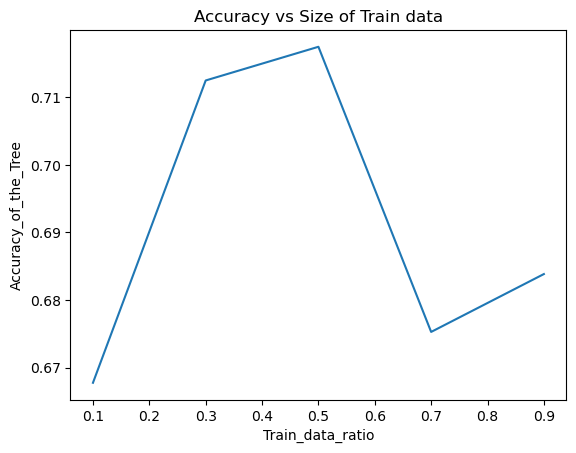

In [332]:
a = 1
split = []
accuracy = []
while a < 10:
    print ('Train : Test =', a,':',10-a )
    X_train, Y_train, X_test , Y_test = data_split(a*0.1)
    classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
    classifier.fit(X_train.T,Y_train)
    classifier.print_tree()
    split.append(a*0.1)
    acc = accuracy_calc( X_test, Y_test)
    accuracy.append(acc)
    print ('Accuracy of the Tree-', acc)
    a = a+2
    
print ('split-', split) 
print ('accuracy-', accuracy) 
plot ( split, accuracy, "Train_data_ratio", "Accuracy_of_the_Tree", "Accuracy vs Size of Train data")

Depth of the Tree = 3
30000
impurity- gini ;  Thresholds-  integer
X_0 <= -23.0 ? 0.07243462975017023
 left:X_4 <= -15.0 ? 0.1387311677006151
  left:X_4 <= -34.0 ? 0.06281745741716
    left:X_3 <= -29.0 ? 0.016609532382067554
        left:6.0
        right:6.0
    right:X_3 <= -17.0 ? 0.07550766532697045
        left:7.0
        right:6.0
  right:X_1 <= -18.0 ? 0.16944603969533656
    left:X_5 <= 23.0 ? 0.14954238087154703
        left:6.0
        right:7.0
    right:X_2 <= 9.0 ? 0.2182550781209036
        left:3.0
        right:2.0
 right:X_3 <= -2.0 ? 0.08243005801551229
  left:X_5 <= 12.0 ? 0.14064112499949366
    left:X_1 <= -33.0 ? 0.16628258909222027
        left:0.0
        right:1.0
    right:X_1 <= 52.0 ? 0.22388523102205632
        left:9.0
        right:2.0
  right:X_2 <= -28.0 ? 0.15189321739557093
    left:X_1 <= -19.0 ? 0.09567969964867917
        left:7.0
        right:4.0
    right:X_1 <= 10.0 ? 0.15663962829569278
        left:8.0
        right:5.0
Accuracy of the Tree

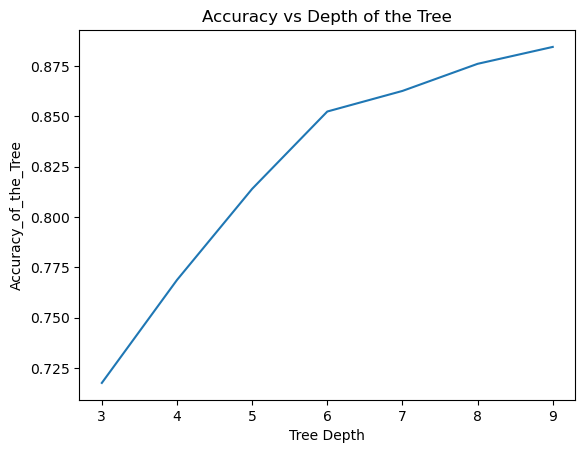

In [333]:
a = 3
spl = []
accuracy = []
while a < 10:
    print ('Depth of the Tree =', a )
    X_train, Y_train, X_test , Y_test = data_split(0.5)
    classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=a)
    classifier.fit(X_train.T,Y_train)
    classifier.print_tree()
    spl.append(a)
    acc = accuracy_calc( X_test, Y_test)
    accuracy.append(acc)
    print ('Accuracy of the Tree-', acc)
    a = a+1
    
print ('Depths-', spl) 
print ('accuracies-', accuracy) 
plot ( spl, accuracy, "Tree Depth", "Accuracy_of_the_Tree", "Accuracy vs Depth of the Tree")

In [334]:
# Y_pred = classifier.predict(X_test.T) 
# print(Y_pred[:10])
# Y_test_= []
# for y in Y_test:
#     Y_test_.append(y[0])
# print(Y_test_[:10])
# from sklearn.metrics import accuracy_score
# accuracy_score(Y_test_, Y_pred)

# K-NN Classifier

The original KMNIST data is computaionally cumbersome to handle in reasonable time, hence the PCA data is used. 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import math
from csv import reader

In [29]:
def read_csv(upload):
    x=[]
    y=[]
    file = open(upload,'r')
    r = reader(file)
    count=1
    for row in r:
        if(count>1):
            x.append(row[1:])
            y.append(row[0])
        count+=1
    return [x,y]

upload = "PCA_MNIST.csv"
data = read_csv(upload)

In [30]:
y_train=data[1]
x_train=np.array(data[0]).astype(np.float64)/255

L=len(y_train)
for i in range(L):
    y_train[i]=float(y_train[i])
    y_train[i]=int(y_train[i])
    
for row in x_train:
    l=len(row)
    for idx in range(l):
        row[idx]=float(row[idx])

In [31]:
def K_NN(vec, label, max_iter):
    #randomly initialise 10 classes
    centroid=[]
    for i in range(10):
        centroid.append(np.random.rand(10))
    l=len(vec)
    count=0
    while(count<10):
        cluster=[[]]*10
        labels=[[]]*10
        for i in range(l):
            cmon=9e7
            index=0
            for j in range(10):
                dist=np.linalg.norm(np.array(vec[i]).astype(np.float64)-np.array(centroid[j]).astype(np.float64))
                if(dist<cmon):
                    cmon=dist
                    index=j
            cluster[index].append(vec[i])
            labels[index].append(label[i])
        for s in range(10):
            sum=np.sum(cluster[s])
            centroid[s]=sum/len(cluster[s])
        count+=1
    return labels

In [32]:
a=K_NN(x_train, y_train, 10)

In [36]:
print(a[0])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 

# GMM Clustering

In [10]:
class GMM_EM:
  #first we define a gaussian mixture model. 
  #The parameters are: g_num = number of gaussians, m_iter=the maximum number of iteration we are going to take in
  #and finally, tol=tolerance which would dictate the algorithm to stop if convergence is achieved before reaching m_iter
  #teh default values are put accordingly


    def __init__(self, m_iter=10, g_num=3, tol=1e-3):
        self.m_iter=m_iter
        self.g_num=g_num
        self.tol=tol

# We initialise the co-variance matrix and the mean in a randomised way in the EM algorithm part later, not here.
#We define the multivariate gaussian for calculation of likelihood probability.

    def train(self, Xd):
        self.x=Xd
        data_point, features = self.x.shape


    #now, initialise the weight matrix. our prior belief is that every point is equally likely to be in each of the gaussians. 
        p_0=1/self.g_num
        self.w=np.array([p_0]*self.g_num)

        #we create the mean matrix which will represent means in d dimensional feature space, as in there will be d columns as in the
        #original data
        #The row size will be equal to the number of gaussians we intend in the model.
        #it will be initialised with random values.
        from numpy.random import rand
        self.mu=rand(self.g_num, features)

        #Now,we create the covariance matrix array which will be an 3D array because each row will now store, a 2D covariance square matrix
        #the number of rows will obviously be equal to that of the number of gaussian components and the row and the column of each 
        #covariance matrix will represent the feature space. 
        #The most general initialisatoin will be that of an identity matrix.

        I=np.eye(features)
        self.cov=np.array([I]*self.g_num) 

        for i in range(self.m_iter):
            post1=self.likelihood(Xd)
            self.update_mu_cov(post1, Xd)
            post2=self.likelihood(Xd)
          #compare the likelihood functions to check for the convergence
            log1=np.sum(np.log(np.sum(post1, axis=1 )))
            log2=np.sum(np.log(np.sum(post2, axis=1 )))
            if((log1-log2)<self.tol):
                break
            self.final_log_likelihood= log2
        return post2


    def likelihood(self, Xd):
    #The likelihood matrix in the columns would have the number of gausian components.
    #In the rows it would have the number of sample points.
    
    #initialise
        data_point, features = Xd.shape
        likelihood=np.zeros((data_point, self.g_num))

    #populate according to the law of weighted likelihood
        for p in range(self.g_num):
            for s in range(data_point):
                likelihood[s, p]=self.w[p]*self.Mult_gauss(Xd[s], self.mu[p], self.cov[p])



    #define posterior
        tot_prob=np.array(np.sum(likelihood, axis=1))
        post=likelihood/tot_prob

        return post


    def update_mu_cov(self, likelihood, Xd):
        data_point, features = Xd.shape
        l=self.likelihood(Xd)

        #sum over all the weighted probabilities over the rows
        sum_p= np.sum(l, axis=0)
        #store it in a column matrix
        sum_col=np.matrix(sum_p).T

        #update the weights as sum_p normalised by the number of data points
        self.w=sum_p/data_point

        #the mean is a matrix which is obtained first by summing over all the previous means and allied probabilities. 
        self.mu=np.dot(l, Xd)
        #divide it by the likelihood sum to normalise
        self.mu= self.mu/sum_col


    #The covariance matrix is a 3D matrix, for each data point create a 2D sqaure matrix by taking dot of appropriate vectors
    #analogous to mean vector
    #iterate over the no of components and then subtract th kth row of the mean matrix from each row of the data matrix.
    #Then sqaure it, multiply with the likelihood entries and normalise to get the kth row of teh cov matrix

        for m in range(self.g_num):
            dist_m=Xd-self.mu[m]
            for i in range(Xd.shape[1]):
                self.cov[m]=[(np.dot(dist_m[:,i], dist_m[:,i]))/Xd.shape[0] for i in range(Xd.shape)]



    def ML_Gauss(self, X):
        X=np.matrix(X)
        col=X.shape[1]
        row=X.shape[0]
        mu_ML=[]
        sigma_ML=[]
        for i in range(col):
            mu_ML.append(X[:,i].mean())
            sigma_ML.append(X[:,i].var())
        return [mu_ML, sigma_ML]

    #n_c for normalisation constant.
    #prec is due to analogy to precision parameter.
    #like is for likelihood
    def Mult_gauss(self, X, mu, sigma):
        col=X.shape[0]
        prod=1
        for i in range(col):
            dist=(X[i]-mu[i])**2/(2*sigma[i]**2)
            n_c=1/(math.sqrt(2*math.pi*sigma[i]))
            p=n_c*math.exp(-dist)
            prod*=p
        return prod

In [ ]:
model=EM_GMM()

model.train(x_train)
model.likelihood(x_train)



[t-SNE] Computing 121 nearest neighbors...


C:\Users\pc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Indexed 60000 samples in 0.363s...
[t-SNE] Computed neighbors for 60000 samples in 72.315s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sample 13000 / 60000
[t-SNE] Computed condit

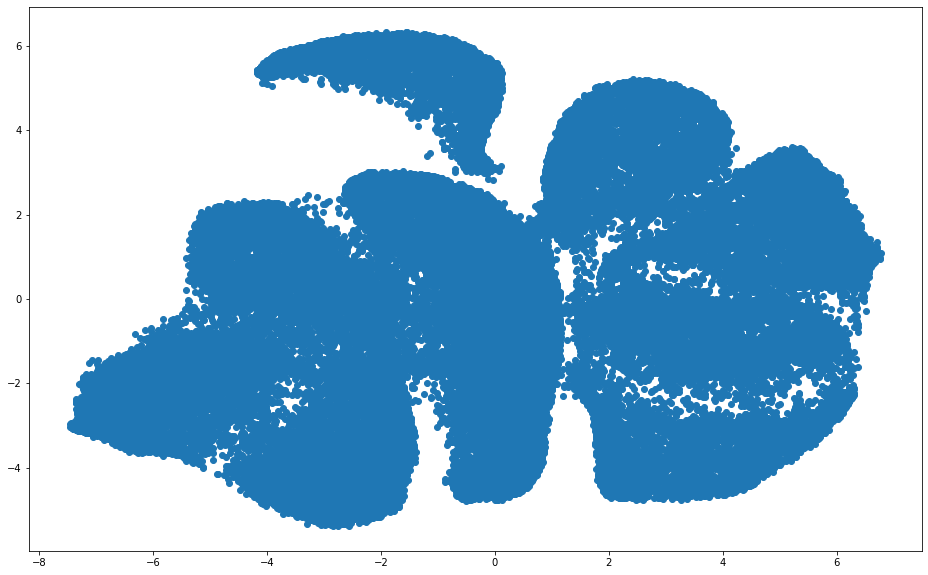

In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_train)

X1= tsne_results[:,0]
Y1= tsne_results[:,1]

plt.figure(figsize=(16,10))
plt.scatter(X1,Y1)
plt.show()

# PCA

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math
from csv import reader

In [19]:
def read_PCA(upload):
    x=[]
    y=[]
    file = open(upload,'r')
    r = reader(file)
    count=1
    for row in r:
        if(count>1):
            x.append(row[1:])
            y.append(row[0])
        count+=1
    return x

upload = "Copy of p4_train.csv"
data = read_PCA(upload)
x_PCA=np.array(data).astype(np.float64)

In [26]:
def PCA(x_PCA, d):
    #d is the number of dimensions to which projection is being done.
    mu=np.mean(x_PCA, axis=0)
    x_PCA=x_PCA-mu
    x_matrix=np.cov(x_PCA.T)
    uval, uvec=np.linalg.eigh(x_matrix)
    return uvec[:d]


def dat_var(x_PCA, d):
    a=PCA(x_PCA,d)
    a=a.T
    mu1=np.mean(a, axis=0)
    a-=mu1
    a=np.matrix(a)
    matrix=np.cov(a.T)
    return np.linalg.det(matrix) 

In [27]:
x=np.arange(100)
y=[]
for ele in x:
    y.append(dat_var(x_PCA, ele))

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(x,y)
plt.title('data variance as a function of dimensions of projection')

In [25]:
print(y)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0]
